In [1]:
import importlib
import matplotlib.pyplot as plt
import benchmark_module
importlib.reload(benchmark_module)

<module 'benchmark_module' from '/home/wolfie/search-forests/benchmark_module.cpython-310-x86_64-linux-gnu.so'>

In [2]:
from benchmark_module import \
    benchmark, \
    generate_zipf_queries, \
    generate_noisy_frequencies, \
    generate_noisy_ranks, \
    generate_noisy_accesses, \
    RandomEngine

In [3]:
NUM_KEYS = 100_000
NUM_QUERIES = 100_000
ZIPF_ALPHA = 1.0
PRED_EPSILON = 1
PRED_DELTA = 0
GEN = RandomEngine(seed=42)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

structures = ["f_forest", "learned_f_forest", "r_forest", "learned_r_forest", "learned_treap", "robustsl", "rb_tree"]
structure_colors = {s: c for s, c in zip(structures, sns.color_palette("tab20", len(structures)))}

In [5]:
def bar_plot_res(li, structures, query_stats, insert_stats, x_label, y_label, show_insert=False, trunc=5):
    w = 0.12
    bar_spacing = 0.02
    group_spacing = 0.16

    group_width = len(structures) * (w + bar_spacing) + group_spacing
    colors = [structure_colors[s] for s in structures]

    if show_insert:
        fig, axes = plt.subplots(1, 2, figsize=(20, 6), constrained_layout=True)
        ax1, ax2 = axes
    else:
        fig, ax2 = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)

    x = range(len(li))

    if show_insert:
        all_insert_values = [insert_stats[a][s] for a in li for s in structures]
        min_insert = min(all_insert_values)
        max_insert = trunc * min_insert

        for i, s in enumerate(structures):
            y = [insert_stats[a][s] for a in li]
            bar_positions = [xi * group_width + i * (w + bar_spacing) for xi in x]
            ax1.bar(bar_positions, [min(v, max_insert) for v in y], width=w, label=s, color=colors[i])
            for j, val in enumerate(y):
                if val > max_insert:
                    ax1.text(bar_positions[j], max_insert + 0.02 * max_insert, f"{val:.2f}",
                             ha='center', va='bottom', fontsize=8, rotation=45)

        ax1.set_ylim(0, max_insert * 1.15)
        ax1.set_xticks([xi * group_width + (len(structures) - 1) * (w + bar_spacing) / 2 for xi in x])
        ax1.set_xticklabels([str(v) for v in li])
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(f"{y_label} (insert)")
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

    all_query_values = [query_stats[a][s] for a in li for s in structures]
    min_query = min(all_query_values)
    max_query = trunc * min_query

    for i, s in enumerate(structures):
        y2 = [query_stats[a][s] for a in li]
        bar_positions = [xi * group_width + i * (w + bar_spacing) for xi in x]
        ax2.bar(bar_positions, [min(v, max_query) for v in y2], width=w, label=s, color=colors[i])
        for j, val in enumerate(y2):
            if val > max_query:
                ax2.text(bar_positions[j], max_query + 0.02 * max_query, f"{val:.2f}",
                         ha='center', va='bottom', fontsize=8, rotation=45)

    ax2.set_ylim(0, max_query * 1.15)
    ax2.set_xticks([xi * group_width + (len(structures) - 1) * (w + bar_spacing) / 2 for xi in x])
    ax2.set_xticklabels([str(v) for v in li])
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(f"{y_label} (query)")
    ax2.grid(axis='y', linestyle='--', alpha=0.5)

    fig.legend(structures, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False)
    plt.show()

In [6]:
def line_plot_res(li, structures, query_stats, insert_stats, x_label, y_label, show_insert=False):
    colors = [structure_colors[s] for s in structures]
    
    if show_insert:
        fig, axes = plt.subplots(1, 2, figsize=(20, 6), constrained_layout=True)
        ax1, ax2 = axes
    else:
        fig, ax2 = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)

    x = list(range(len(li)))

    if show_insert:
        for i, s in enumerate(structures):
            y = [insert_stats[a][s] for a in li]
            ax1.plot(x, y, label=s, color=colors[i], marker='o')

        ax1.set_xticks(x)
        ax1.set_xticklabels([str(v) for v in li])
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(f"{y_label} (insert)")
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

    for i, s in enumerate(structures):
        y2 = [query_stats[a][s] for a in li]
        ax2.plot(x, y2, label=s, color=colors[i], marker='o')

    ax2.set_xticks(x)
    ax2.set_xticklabels([str(v) for v in li])
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(f"{y_label} (query)")
    ax2.grid(axis='y', linestyle='--', alpha=0.5)

    fig.legend(structures, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False)
    plt.show()

In [7]:
def run_key_experiments(num_keys_options, num_queries, alpha, epsilon, delta, gen):
    query_stats = {}
    insert_stats = {}
        
    for num_keys in num_keys_options:
        queries = generate_zipf_queries(num_keys * 1000, num_queries, alpha, gen)
        frequencies = generate_noisy_frequencies(queries, num_keys * 1000, epsilon, delta, gen)
        ranks = generate_noisy_ranks(frequencies, epsilon, delta, gen)
        accesses = generate_noisy_accesses(queries, num_keys * 1000, epsilon, delta, gen)
        out = benchmark(queries, frequencies, ranks, accesses, gen)

        query_stats[num_keys] = out["queries"]["comparisons"]
        insert_stats[num_keys] = out["inserts"]["comparisons"]
        print(out["queries"]["compactions"])
        
    structures = list(query_stats[num_keys_options[0]].keys())
    x_label = "Number of keys (thousands)"
    y_label = f"Average number of comparisons"
    
    line_plot_res(num_keys_options, structures, query_stats, insert_stats, x_label, y_label, True)


{'f_forest': 16969, 'learned_f_forest': 0, 'r_forest': 222584, 'learned_r_forest': 8034}
{'f_forest': 17909, 'learned_f_forest': 0, 'r_forest': 261559, 'learned_r_forest': 43706}
{'f_forest': 17192, 'learned_f_forest': 0, 'r_forest': 274450, 'learned_r_forest': 89765}
{'f_forest': 16575, 'learned_f_forest': 0, 'r_forest': 280510, 'learned_r_forest': 140602}
{'f_forest': 15968, 'learned_f_forest': 0, 'r_forest': 284745, 'learned_r_forest': 195349}
{'f_forest': 15371, 'learned_f_forest': 0, 'r_forest': 287097, 'learned_r_forest': 254596}
{'f_forest': 14989, 'learned_f_forest': 0, 'r_forest': 288887, 'learned_r_forest': 270655}
{'f_forest': 24252, 'learned_f_forest': 0, 'r_forest': 301173, 'learned_r_forest': 317112}
{'f_forest': 30560, 'learned_f_forest': 0, 'r_forest': 312368, 'learned_r_forest': 358472}
{'f_forest': 35664, 'learned_f_forest': 0, 'r_forest': 321441, 'learned_r_forest': 383477}
{'f_forest': 38345, 'learned_f_forest': 0, 'r_forest': 328628, 'learned_r_forest': 450483}
{'f

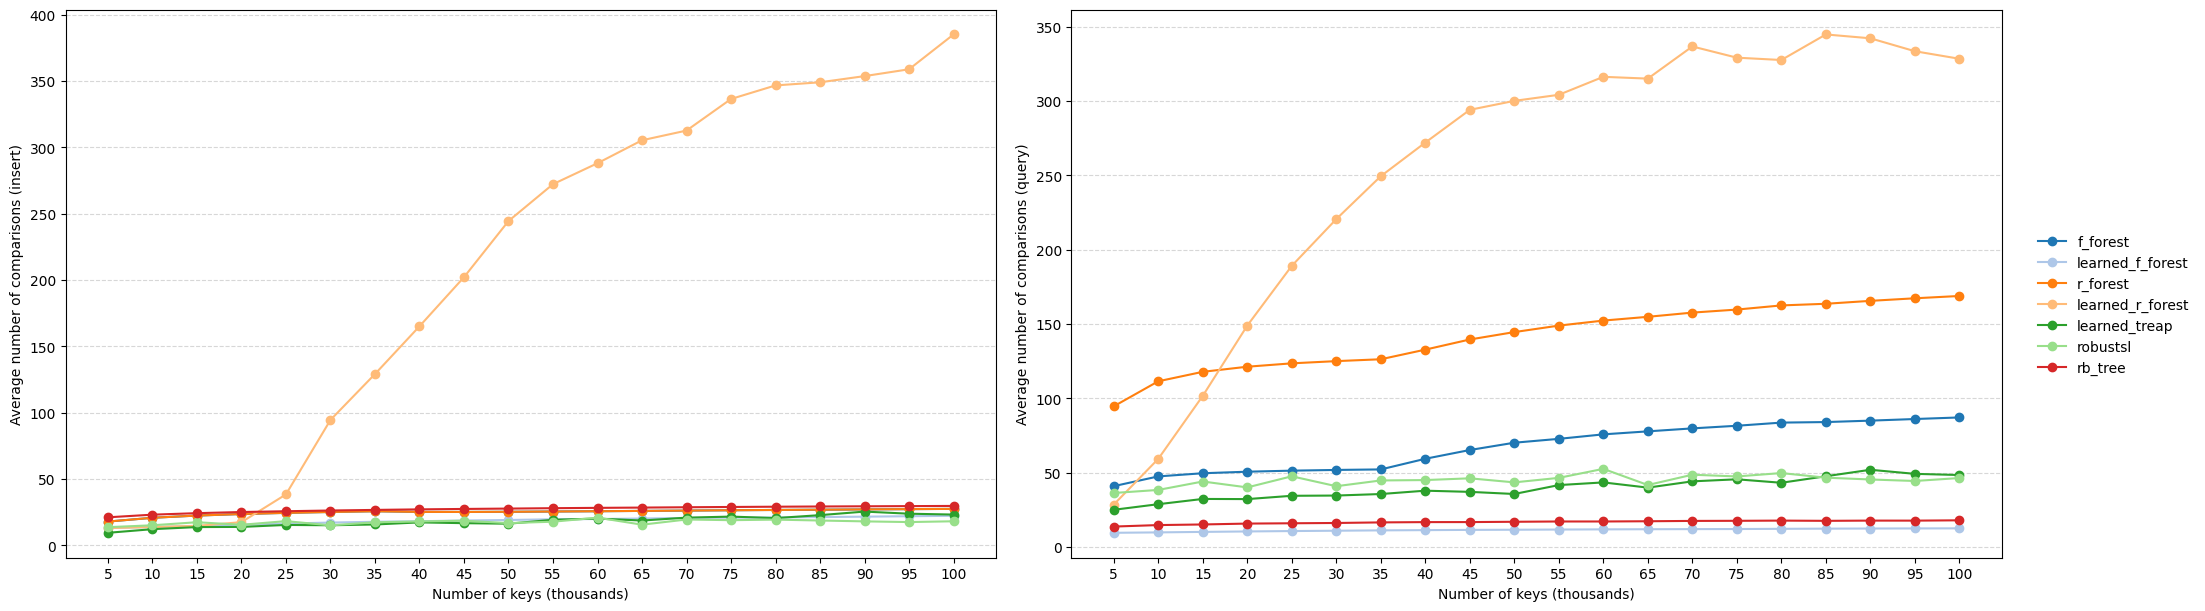

In [8]:
num_keys_options = [5 * i for i in range(1, 21)]
run_key_experiments(num_keys_options, NUM_QUERIES, ZIPF_ALPHA, PRED_EPSILON, PRED_DELTA, GEN)

In [9]:
def run_alpha_experiments(num_keys, num_queries, alpha_options, epsilon, delta, gen):
    query_stats = {}
        
    for alpha in alpha_options:
        queries = generate_zipf_queries(num_keys, num_queries, alpha, gen)
        frequencies = generate_noisy_frequencies(queries, num_keys, epsilon, delta, gen)
        ranks = generate_noisy_ranks(frequencies, epsilon, delta, gen)
        accesses = generate_noisy_accesses(queries, num_keys, epsilon, delta, gen)
        out = benchmark(queries, frequencies, ranks, accesses, gen)

        query_stats[alpha] = out["queries"]["comparisons"]
        
    structures = list(query_stats[alpha_options[0]].keys())
    x_label = "Zipf parameter alpha"
    y_label = f"Average number of comparisons"

    bar_plot_res(alpha_options, structures, query_stats, None, x_label, y_label)

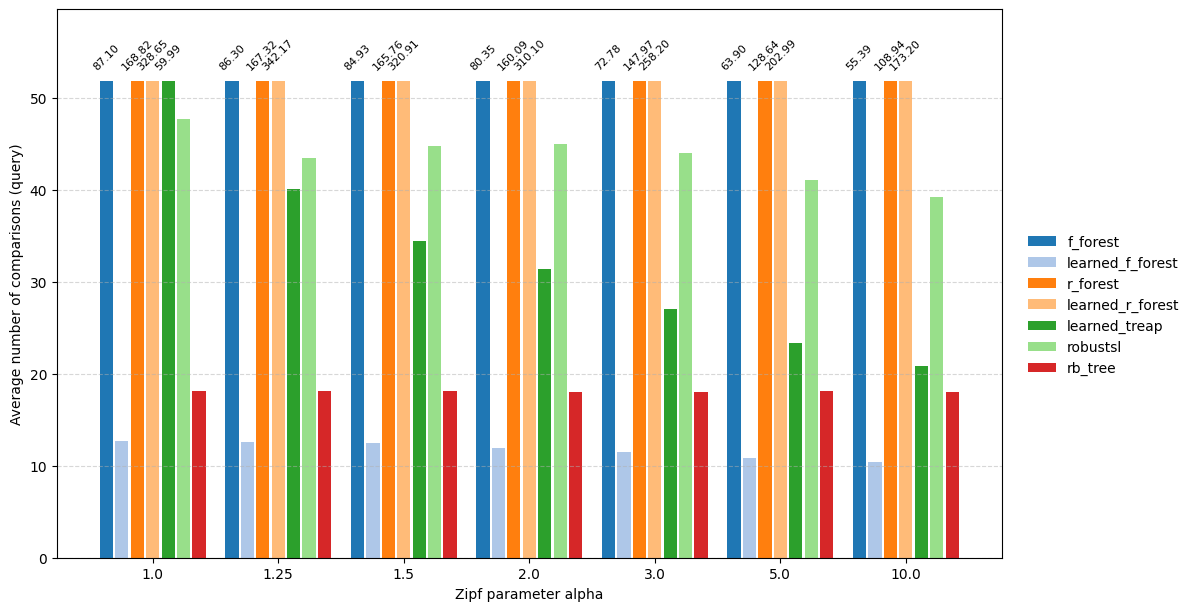

In [10]:
alpha_options = [1., 1.25, 1.5, 2., 3., 5., 10.]
run_alpha_experiments(NUM_KEYS, NUM_QUERIES, alpha_options, PRED_EPSILON, PRED_DELTA, GEN)

In [11]:
def run_freq_error_experiments(num_keys, num_queries, alpha, error_options, gen):
    query_stats = {}
        
    queries = generate_zipf_queries(num_keys, num_queries, alpha, gen)
    perf_epsilon, perf_delta = error_options[0]
    
    for error in error_options:
        epsilon, delta = error
        frequencies = generate_noisy_frequencies(queries, num_keys, epsilon, delta, gen)
        ranks = generate_noisy_ranks(frequencies, perf_epsilon, perf_delta, gen)
        accesses = generate_noisy_accesses(queries, num_keys, perf_epsilon, perf_delta, gen)
        out = benchmark(queries, frequencies, ranks, accesses, gen)

        query_stats[error] = out["queries"]["comparisons"]
        del query_stats[error]["f_forest"]
        del query_stats[error]["r_forest"]
        del query_stats[error]["learned_r_forest"]
        
    structures = list(query_stats[error_options[0]].keys())
    x_label = "Error parameters (epsilon, delta)"
    y_label = f"Average number of comparisons"
    
    bar_plot_res(error_options, structures, query_stats, None, x_label, y_label)

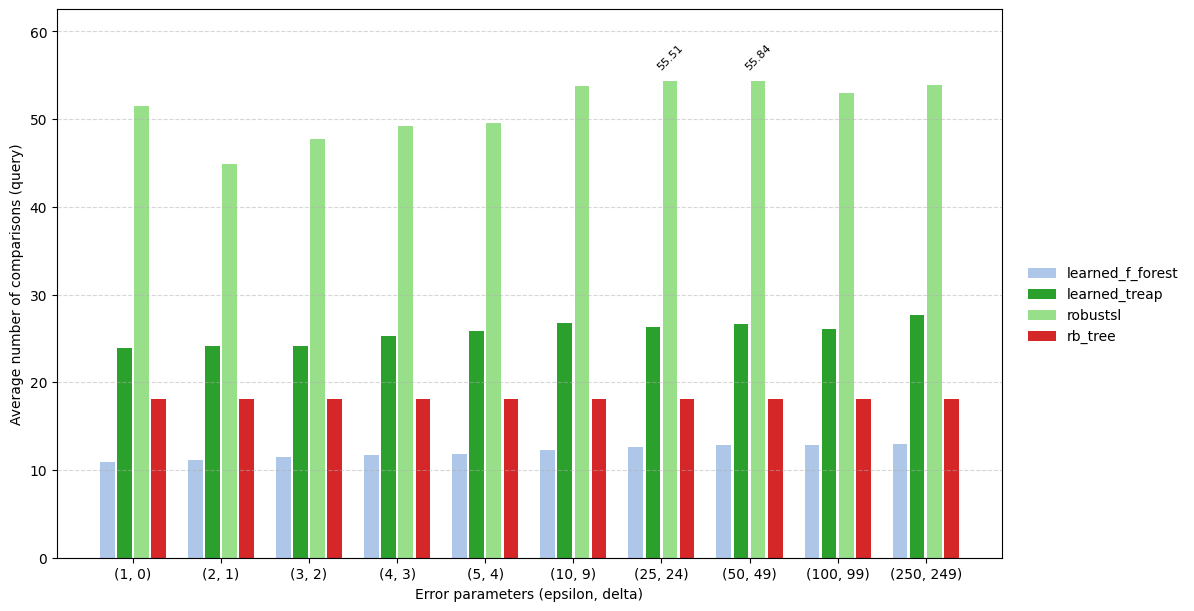

In [12]:
error_options = [(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (10, 9), (25, 24), (50, 49), (100, 99), (250, 249)]
run_freq_error_experiments(NUM_KEYS, NUM_QUERIES, 5.0, error_options, GEN)

In [13]:
def run_rank_error_experiments(num_keys, num_queries, alpha, error_options, gen):
    query_stats = {}
        
    queries = generate_zipf_queries(num_keys, num_queries, alpha, gen)
    perf_epsilon, perf_delta = error_options[0]
    
    for error in error_options:
        epsilon, delta = error
        frequencies = generate_noisy_frequencies(queries, num_keys, perf_epsilon, perf_delta, gen)
        ranks = generate_noisy_ranks(frequencies, epsilon, delta, gen)
        accesses = generate_noisy_accesses(queries, num_keys, perf_epsilon, perf_delta, gen)
        out = benchmark(queries, frequencies, ranks, accesses, gen)

        query_stats[error] = out["queries"]["comparisons"]
        del query_stats[error]["f_forest"]
        del query_stats[error]["r_forest"]
        del query_stats[error]["learned_r_forest"]
        del query_stats[error]["robustsl"]
        
    structures = list(query_stats[error_options[0]].keys())
    x_label = "Error parameters (epsilon, delta)"
    y_label = f"Average number of comparisons" 
    
    bar_plot_res(error_options, structures, query_stats, None, x_label, y_label, False, 20)

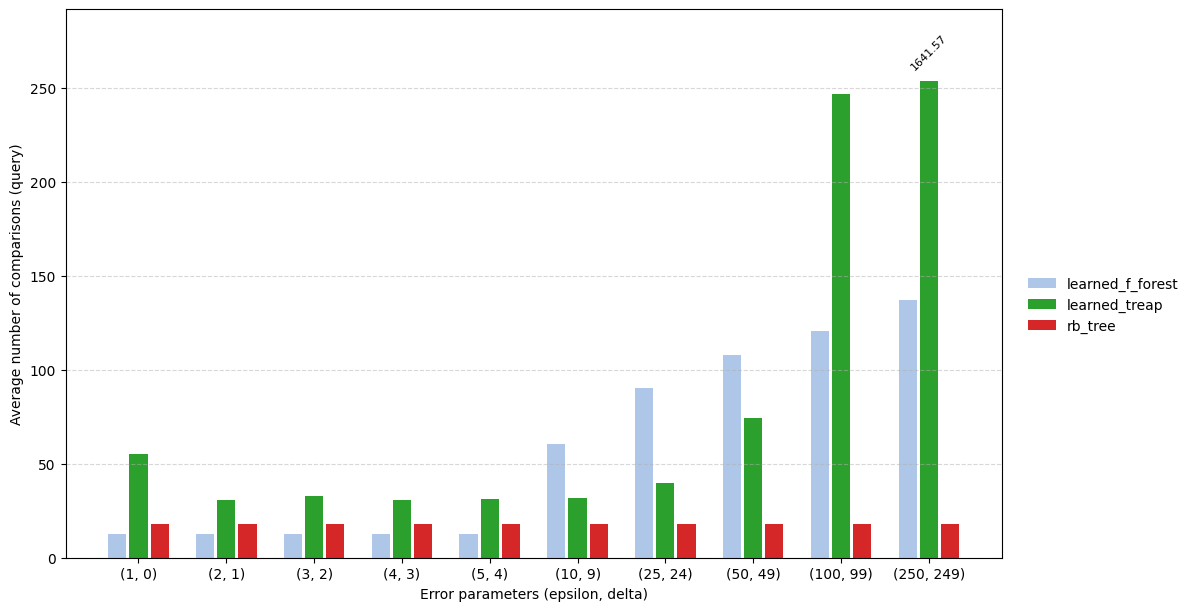

In [14]:
error_options = [(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (10, 9), (25, 24), (50, 49), (100, 99), (250, 249)]
run_rank_error_experiments(NUM_KEYS, NUM_QUERIES, ZIPF_ALPHA, error_options, GEN)